<a href="https://colab.research.google.com/github/allen-del/Learning_PyTorch/blob/main/02.%20Binary%20and%20Multiclass%20Classification%20using%20Neural%20Networks%20/%2002_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. PyTorch Classification Exercises


In [8]:
# Import torch
import torch

# Setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [9]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons

X, y = make_moons(n_samples = 1000, noise = 0.2, random_state = 42)


In [10]:
# Turn data into a DataFrame
import pandas as pd

data_inPandas = pd.DataFrame({"X1": X[:,0],
                    "X2": X[:,1],
                    "y" : y[:]})

data_inPandas.head(5)


,X1,X2,y
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0


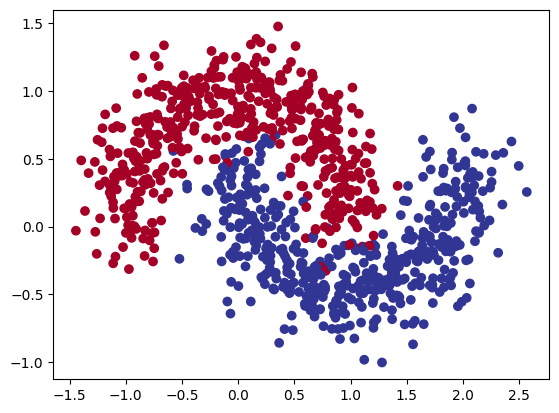

In [11]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c = y, cmap = plt.cm.RdYlBu)


In [12]:
# Turn data into tensors of dtype float

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [206]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    def __init__(self, hidden_units = 8):
      super().__init__()

      self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features = 2, out_features = hidden_units),
          nn.ReLU(),
          nn.Linear(in_features = hidden_units, out_features = hidden_units),
          nn.ReLU(),
          nn.Linear(in_features = hidden_units, out_features = 1),
          # nn.ReLU(),
          # nn.Linear(in_features = hidden_units, out_features = 1)           #Tried increasing hidden layers but it reduced accuracy

          )


    def forward(self, x):
        return self.linear_layer_stack(x)

# Instantiate the model

HIDDEN_UNITS = 10
model_0 = MoonModelV0(hidden_units = HIDDEN_UNITS)

next(model_0.parameters()).to(device)

Parameter containing:
tensor([[ 0.1397, -0.4429],
        [-0.4075,  0.3200],
        [ 0.2809, -0.0852],
        [ 0.0974, -0.0940],
        [-0.6437, -0.2829],
        [-0.3956, -0.3847],
        [-0.1997, -0.2629],
        [ 0.6684,  0.6200],
        [-0.5157,  0.6838],
        [ 0.7003, -0.4712]], requires_grad=True)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [207]:
# Setup loss function

loss_fn = torch.nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.5)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [51]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
#!pip -q install torchmetrics
from torchmetrics.classification import BinaryAccuracy

acc_fn = (BinaryAccuracy()*100).to(device) # send accuracy function to device
acc_fn

CompositionalMetric(
  mul(
    BinaryAccuracy(),
    100
  )
)

In [36]:
#y_train.shape, model_0(X_train).squeeze().shape

#Debugging shape error

In [208]:
epochs = 250

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()

  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)

  acc = acc_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

    if epoch%10 == 0:
      print(f"{epoch} Epochs || Train Loss: {loss}, Accuracy: {acc} || Test Loss: {test_loss}, Accuracy: {test_acc}")


0 Epochs || Train Loss: 0.6983906626701355, Accuracy: 42.875 || Test Loss: 0.6918705701828003, Accuracy: 57.5
10 Epochs || Train Loss: 0.6045714020729065, Accuracy: 77.875 || Test Loss: 0.60093092918396, Accuracy: 72.5
20 Epochs || Train Loss: 0.4664912819862366, Accuracy: 79.875 || Test Loss: 0.47897616028785706, Accuracy: 77.5
30 Epochs || Train Loss: 0.3786545693874359, Accuracy: 83.75 || Test Loss: 0.3907255530357361, Accuracy: 81.0
40 Epochs || Train Loss: 0.3254542946815491, Accuracy: 85.75 || Test Loss: 0.3313101828098297, Accuracy: 83.5
50 Epochs || Train Loss: 0.29851651191711426, Accuracy: 87.0 || Test Loss: 0.3004441261291504, Accuracy: 86.5
60 Epochs || Train Loss: 0.2859955132007599, Accuracy: 87.375 || Test Loss: 0.2855449616909027, Accuracy: 87.5
70 Epochs || Train Loss: 0.2780562937259674, Accuracy: 87.375 || Test Loss: 0.27609214186668396, Accuracy: 87.5
80 Epochs || Train Loss: 0.2711418569087982, Accuracy: 87.875 || Test Loss: 0.2678683400154114, Accuracy: 87.5
90 Ep

I challenged myself to get to get accuracy > 96% in 250 epochs.

What I tried:

* **Adjusted the number of hidden units** - `16` took longer and `8` also took longer than 10 to get to desired accuracy.

* **Adjusted the number of hidden layers** - Adding one more hidden layer significantly decreased how fast the model was learning. *Probably [overfitting](https://stats.stackexchange.com/questions/338255/what-is-effect-of-increasing-number-of-hidden-layers-in-a-feed-forward-nn)*
* **Changing Learning rate** - Increasing the learning rate to `0.5` helped converge fast to a solution where Accuracy > 96%.

[See Also](https://medium.com/deep-learning-hk/some-techniques-in-deep-learning-optimization-1-learning-rate-b4669d5bb568)

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [209]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

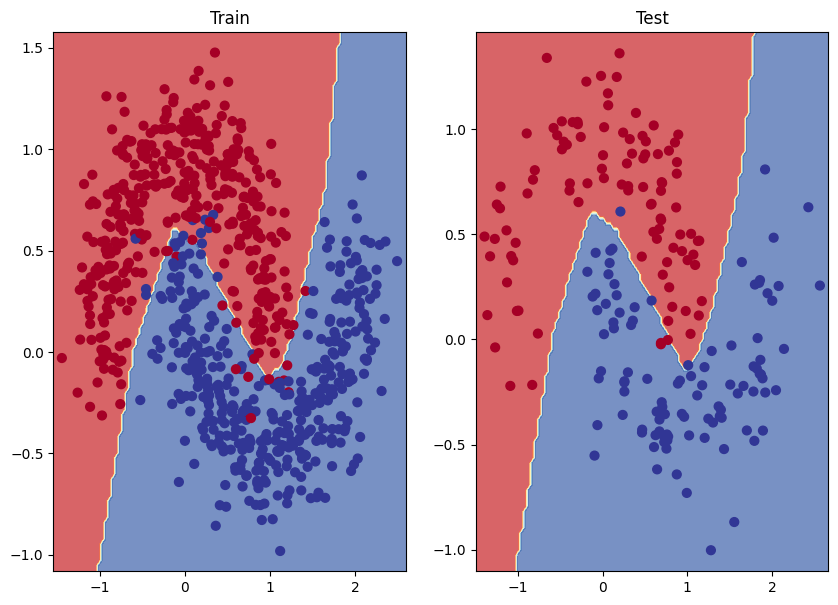

In [210]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

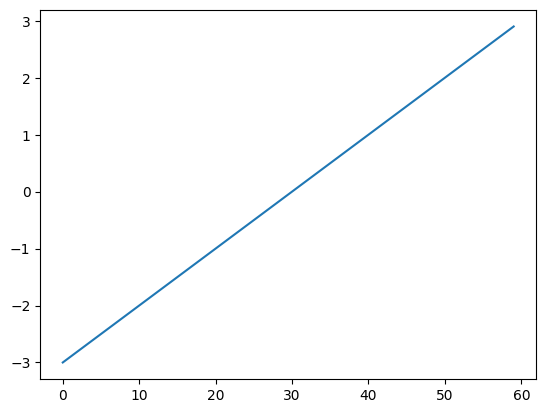

In [216]:
# Create a straight line tensor

A = torch.arange(-3,3,0.1)

def homemade_tanh(x):
  return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

plt.plot(A)


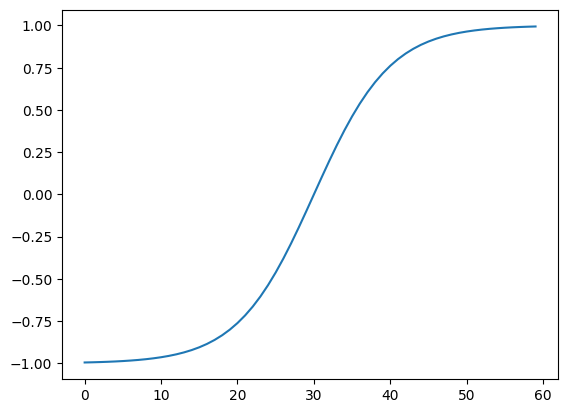

In [217]:
# Test torch.tanh() on the tensor and plot it

plt.plot(torch.tanh(A))



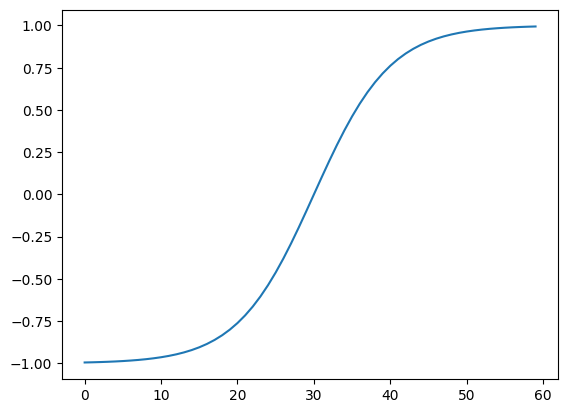

In [218]:
# Replicate torch.tanh() and plot it

plt.plot(homemade_tanh(A))

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

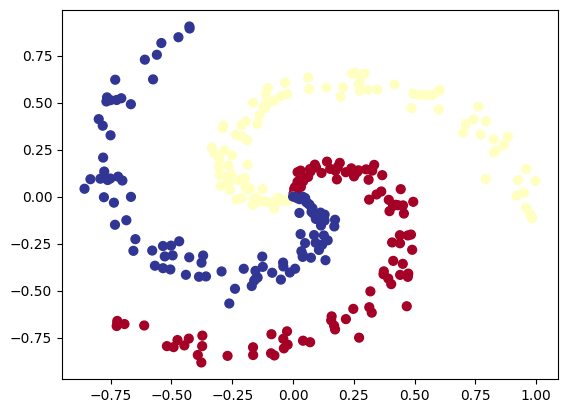

In [223]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [224]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_test), len(y_test)


(240, 240, 60, 60)

In [227]:
X_train.shape, y_train.shape

(torch.Size([240, 2]), torch.Size([240]))

In [236]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = (Accuracy(task="multiclass", num_classes=4)*100).to(device)
acc_fn

CompositionalMetric(
  mul(
    MulticlassAccuracy(),
    100
  )
)

In [274]:
# Prepare device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create model by subclassing nn.Module

class SpiralClassifierV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
        )

  def forward(self, x):
    return self.layer_stack(x)

# Instantiate model and send it to device

INPUT_FEATURES = 2
OUTPUT_FEATURES = 3
HIDDEN_UNITS = 8

model_1 = SpiralClassifierV0(input_features = INPUT_FEATURES, output_features = OUTPUT_FEATURES, hidden_units = HIDDEN_UNITS).to(device)

next(model_1.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998]], requires_grad=True)

In [256]:
# Setup data to be device agnostic

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)


# Print out first 10 untrained model outputs (forward pass)

model_1.eval()
with torch.inference_mode():

  y_logits = model_1(X_train)
  print(f"Logits: {y_logits[:10]}")

  y_pred = y_logits.softmax(dim = 1)

  print(f"Pred probs: {y_pred[:10]}")

  y_label = y_pred.argmax(dim = 1)

  print(f"Pred labels: {y_label[:10]}")


Logits: tensor([[-0.3496,  0.2430,  0.1072],
        [-0.3495,  0.2419,  0.1052],
        [-0.3461,  0.2563,  0.1100],
        [-0.3380,  0.2785,  0.1040],
        [-0.3383,  0.2794,  0.1079],
        [-0.3430,  0.2645,  0.1081],
        [-0.3441,  0.2624,  0.1100],
        [-0.3551,  0.2324,  0.1126],
        [-0.3451,  0.2540,  0.1033],
        [-0.3378,  0.2789,  0.1039]])
Pred probs: tensor([[0.2279, 0.4122, 0.3599],
        [0.2282, 0.4122, 0.3596],
        [0.2270, 0.4147, 0.3583],
        [0.2269, 0.4202, 0.3529],
        [0.2264, 0.4199, 0.3537],
        [0.2270, 0.4167, 0.3563],
        [0.2268, 0.4160, 0.3572],
        [0.2275, 0.4094, 0.3631],
        [0.2280, 0.4150, 0.3570],
        [0.2269, 0.4203, 0.3528]])
Pred labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [275]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( params = model_1.parameters(),
                             lr = 0.1)

In [276]:
# Build a training loop for the model

epoch_list = []

train_loss_list = []

test_loss_list = []

torch.manual_seed(42)

torch.cuda.manual_seed(42)

epochs = 100

# Loop over data

for epoch in range(epochs):


  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_train)
  acc = acc_fn(y_pred, y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  ## Testing

  model_1.eval()
  with torch.inference_mode():

    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred, y_test)

    epoch_list.append(epoch)
    train_loss_list.append(loss.detach())
    test_loss_list.append(test_loss)

    if epoch % 10 == 0:

      print(f"{epoch} Epochs || Train loss: {loss: .4f}, Accuracy: {acc: .2f} || Test Loss {test_loss: .4f}, Accuracy: {test_acc: .2f}")


0 Epochs || Train loss:  1.1011, Accuracy:  40.42 || Test Loss  1.0707, Accuracy:  48.33
10 Epochs || Train loss:  0.7029, Accuracy:  55.83 || Test Loss  0.6550, Accuracy:  65.00
20 Epochs || Train loss:  0.2683, Accuracy:  88.33 || Test Loss  0.1929, Accuracy:  93.33
30 Epochs || Train loss:  0.1067, Accuracy:  95.83 || Test Loss  0.0650, Accuracy:  98.33
40 Epochs || Train loss:  0.0935, Accuracy:  95.00 || Test Loss  0.0370, Accuracy:  100.00
50 Epochs || Train loss:  0.0766, Accuracy:  98.33 || Test Loss  0.0221, Accuracy:  100.00
60 Epochs || Train loss:  0.0661, Accuracy:  96.25 || Test Loss  0.0170, Accuracy:  100.00
70 Epochs || Train loss:  0.0415, Accuracy:  99.17 || Test Loss  0.0111, Accuracy:  100.00
80 Epochs || Train loss:  0.0321, Accuracy:  99.17 || Test Loss  0.0146, Accuracy:  100.00
90 Epochs || Train loss:  0.0296, Accuracy:  99.17 || Test Loss  0.0113, Accuracy:  100.00


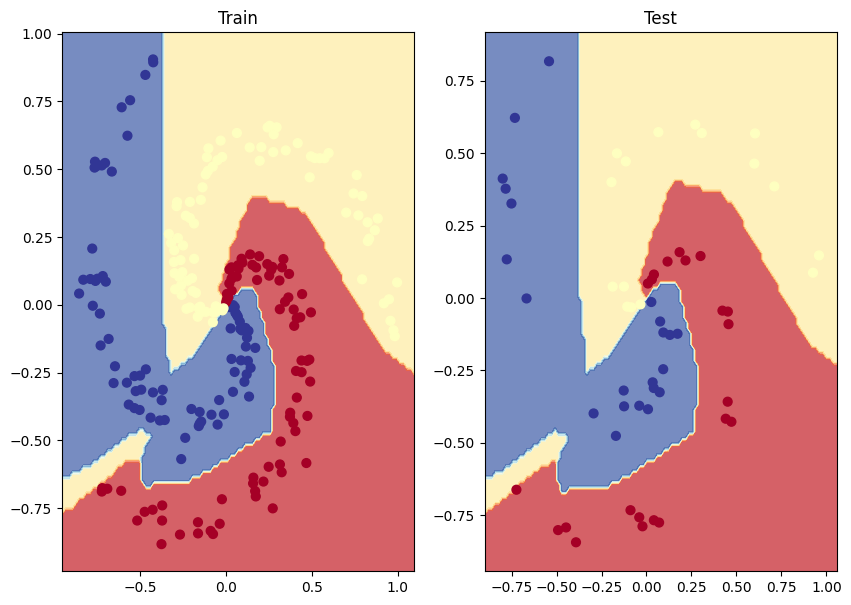

In [277]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(10,7))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)




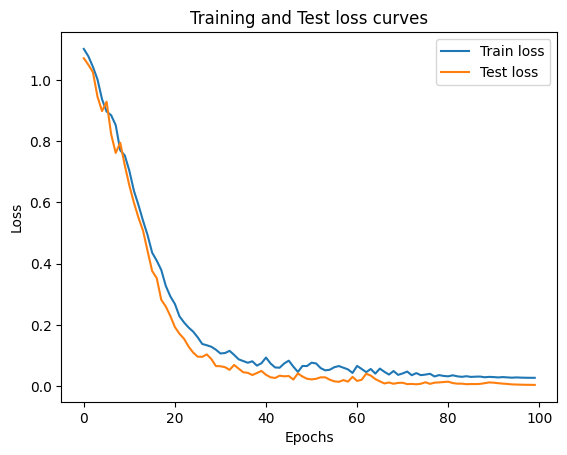

In [278]:
plt.plot(epoch_list, train_loss_list, label='Train loss')
plt.plot(epoch_list, test_loss_list, label='Test loss')
plt.title('Training and Test loss curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend();